Work in Progress: In-Motion Predictability
==========================================

Hey folks! This is my first try at submitting a notebook for the Big Data Bowl. I've got the start of an idea, and I would love to get thoughts and comments and feedback on this.

More and more teams are using motion before the snap. How much does a team broadcast what it is doing when a player is going into motion? Are certain receivers more or less likely to be targeted when going into motion? Which teams / players play their cards "close to the vest" and have the same targeting statistics while in motion or not?

For the purposes of this initial analysis, I'm focused on 3 files from the Big Data Bowl: players.csv, games.csv and player_play.csv. This data is loaded and merged into a single pandas dataframe. To maintain data for later training, I'm only looking at the first 6 weeks of data.

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt

data_dir = "../data/kaggle"

# load game data, get array of games in week 1
df_gs = pd.read_csv(f"{data_dir}/games.csv")
df_pp = pd.read_csv(f"{data_dir}/player_play.csv")
df_ps = pd.read_csv(f"{data_dir}/players.csv")

start = 1
end   = 6

df_gs_range = df_gs[ df_gs["week"].isin(range(start, end+1)) ]
print(f"INFO: Found {len(df_gs_range.index)} total games from week {start} through week {end}")
print()

# load player play data, limited to start and end week
list_games = df_gs_range[ "gameId" ].unique()
df_pp_range = df_pp[ df_pp["gameId"].isin(list_games) ]

# load player data, merge display name and positions into player play data
df_player_pos = df_ps[[ "nflId", "displayName", "position" ]]
df_pp_merge = df_pp_range.merge(df_player_pos, on="nflId")

#print("Columns in player play data:")
#print(df_pp_merge.columns.values)


INFO: Found 94 total games from week 1 through week 6



# How Many Plays?

In analyizing all of the plays in the dataset, this model assumes that only wide receivers, running backs and tight ends are eligible receivers. Given that, are certain receivers favored (or not) if they are in motion on the play?

I start this by making a list of every receiver in the games in the dataset, and a count of each play they are in. Iterating over this list of receivers, how many times was each receiver is targeted, and how many times did they go into motion?

Once I break down the groupings of plays with motion / no motion or target / no-target, I can run analysis on whether motion (or lack of motion) impacts the chances of being targeted on a play.

In [12]:
total_plays = int(len(df_pp_merge.index) / 22)

df_receiver_plays = df_pp_merge[ df_pp_merge[ "position" ].isin(["WR", "RB", "TE"]) ]
s_receiver_counts = df_receiver_plays['nflId'].value_counts()

df_receiver_counts = s_receiver_counts.to_frame()
print(f"INFO: {len(df_receiver_counts.index)} receivers, tight ends and running backs found in {total_plays} plays\n")

INFO: 437 receivers, tight ends and running backs found in 11152 plays



In [13]:
for k, row in df_receiver_counts.iterrows():

    # pull player info from one line 
    df_k_plays = df_receiver_plays[ (df_receiver_plays[ "nflId" ] == k) ]
    
    df_receiver_counts.loc[k, "displayName"] = df_k_plays["displayName"].iloc[0]
    df_receiver_counts.loc[k, "teamAbbr"] = df_k_plays["teamAbbr"].iloc[0]
    df_receiver_counts.loc[k, "position"] = df_k_plays["position"].iloc[0]

    df_target_all = df_k_plays[ df_k_plays[ "wasTargettedReceiver" ] == 1 ]
    df_motion_all = df_k_plays[ df_k_plays[ "motionSinceLineset" ] == 1 ]

    df_motion_target = df_k_plays[ ( df_k_plays[ "wasTargettedReceiver" ] == 1 ) & \
                                   ( df_k_plays[ "motionSinceLineset" ] == 1 ) 
                                 ]   
    df_nomotion_target = df_k_plays[ ( df_k_plays[ "wasTargettedReceiver" ] == 1 ) & \
                                     ( df_k_plays[ "motionSinceLineset" ] == 0 ) 
                                   ]
    df_motion_notarget = df_k_plays[ ( df_k_plays[ "wasTargettedReceiver" ] == 0 ) & \
                                     ( df_k_plays[ "motionSinceLineset" ] == 1 ) 
                                   ] 
    df_nomotion_notarget = df_k_plays[ ( df_k_plays[ "wasTargettedReceiver" ] == 0 ) & \
                                       ( df_k_plays[ "motionSinceLineset" ] == 0 ) 
                                     ]
    
    df_receiver_counts.loc[k, "countTargets"] = len(df_target_all)
    df_receiver_counts.loc[k, "countMotions"] = len(df_motion_all)
    df_receiver_counts.loc[k, "countMotionTargets"] = len(df_motion_target)
    df_receiver_counts.loc[k, "countMotionNoTargets"] = len(df_motion_notarget)
    df_receiver_counts.loc[k, "countNoMotionTargets"] = len(df_nomotion_target)
    df_receiver_counts.loc[k, "countNoMotionNoTargets"] = len(df_nomotion_notarget)

    df_receiver_counts.loc[k, "pctTargetsAllPlays" ] = len(df_target_all) / row["count"]
    if len(df_motion_all) > 0:
        df_receiver_counts.loc[k, "pctTargetsMotionPlays" ] = len(df_motion_target) / len(df_motion_all)
        df_receiver_counts.loc[k, "pctDiffMotionsOverAll" ] = (len(df_motion_target) / len(df_motion_all)) - \
            (len(df_target_all) / row["count"])
        df_receiver_counts.loc[k, "pctAbsoluteDiffMotions" ] = abs((len(df_motion_target) / len(df_motion_all)) - \
            (len(df_target_all) / row["count"]))
    else:
        df_receiver_counts.loc[k, "pctTargetsMotionPlays" ] = np.nan
        df_receiver_counts.loc[k, "pctDiffMotionsOverAll" ] = np.nan
        df_receiver_counts.loc[k, "pctAbsoluteDiffMotions" ] = np.nan

    df_receiver_counts.loc[k, "pctTargetsMotionOverAll" ] = len(df_motion_target) / row["count"]

df_receiver_counts.sort_values(by=['countMotions'], ascending=False, inplace=True)

#print("Processed motion and target stats:")
#print(df_receiver_counts.columns.values)
#print()
#print(df_receiver_counts)

# Set Target Thresholds

I'm not interested in receivers that receive no targets. Therefore, I need to set minimum threshold for what precentage of plays a receiver is targeted. I walso want to set a minimum number of targets. In the case of this notebook, I am setting the threshold to being targeted on at least 3% of plays over at least 4 targets.

In [14]:
pct_target_threshold = .03
sum_target_threshold = 4
sum_motion_threshold = 5

df_minimum_motions = df_receiver_counts[ ( df_receiver_counts["pctTargetsAllPlays"] > pct_target_threshold ) & \
                                         ( df_receiver_counts["countMotions"] >= sum_motion_threshold ) & \
                                         ( df_receiver_counts["countTargets"] >= sum_target_threshold ) ].copy()
print(f"INFO: Found {len(df_minimum_motions)} receivers with at least {sum_target_threshold} targets, " \
      f"and targets on more than {pct_target_threshold*100}% of all plays\n")

INFO: Found 226 receivers with at least 4 targets, and targets on more than 3.0% of all plays



# Output Most Interesting Players

To validate the data analysis, I can print the "least predictable" and the "most predicatable" players. This is caclulated by sorting the list of players according to the difference between percentage of targets on in-motion plays, versus percentage of targets on all plays.

In [15]:
def print_players(count, sort_field, find_least):

    df_minimum_motions.sort_values(by=[sort_field], ascending=find_least, inplace=True)

    if find_least:
        df_top = df_minimum_motions[:top_count].copy()
        print(f"Top {top_count} Least Predictable Players")
    else:
        df_top = df_minimum_motions[:top_count].copy()
        print(f"Top {top_count} Most Predictable Players")
    print()
    
    for i, row in df_top.iterrows():

        name = row["displayName"]
        team = row["teamAbbr"]
        pos = row["position"]
        motions = row["countMotions"]
        pct_motion_targets = row["pctTargetsMotionPlays"]
        pct_all_targets = row["pctTargetsAllPlays"]
        count_plays = row["count"]
    
        print(f"{name:22} {pos:2}, {team:4} targeted {round(pct_motion_targets * 100, 2):5}% of {int(motions):2} " \
            f"motions; {round(pct_all_targets * 100,2):5}% of {count_plays:3} total plays" \
            f"(diff: {round(row['pctDiffMotionsOverAll']*100,2):5}%)")

#find_least = True
#sort_field = 'pctAbsoluteDiffMotions'

print_players(10, 'pctAbsoluteDiffMotions', True)
print()
print_players(10, 'pctAbsoluteDiffMotions', False)


Top 10 Least Predictable Players

Jaylen Waddle          WR, MIA  targeted 18.18% of 11 motions; 18.01% of 272 total plays(diff:  0.17%)
Dalvin Cook            RB, MIN  targeted  5.56% of 18 motions;  5.74% of 244 total plays(diff: -0.18%)
Najee Harris           RB, PIT  targeted  7.14% of 14 motions;  7.33% of 232 total plays(diff: -0.18%)
Nick Chubb             RB, CLE  targeted   5.0% of 20 motions;  5.21% of 211 total plays(diff: -0.21%)
Mark Andrews           TE, BAL  targeted 18.75% of 16 motions; 18.49% of 292 total plays(diff:  0.26%)
Mike Gesicki           TE, MIA  targeted  9.68% of 31 motions;  9.94% of 181 total plays(diff: -0.27%)
Javonte Williams       RB, DEN  targeted 16.67% of  6 motions; 17.05% of 129 total plays(diff: -0.39%)
Brandon Aiyuk          WR, SF   targeted 11.11% of  9 motions; 11.55% of 303 total plays(diff: -0.44%)
Dawson Knox            TE, BUF  targeted  8.33% of 24 motions;  7.66% of 248 total plays(diff:  0.67%)
Jahan Dotson           WR, WAS  targete

# Plot Diff of In-Motion vs. Targeted Plays

Which receivers are more predictable by motion? Meaning, if they go into motion, can the model predict if they WILL or WON'T get targeted? The best way to do this is to map the absolute difference in precentages between motion targets and all targets. From there, I can use logistic regression to set a **decision boundary** for all of our players.

For future predictions, I can use this decision boundary to test against predictability in future games, to see if our model stands up to testing.

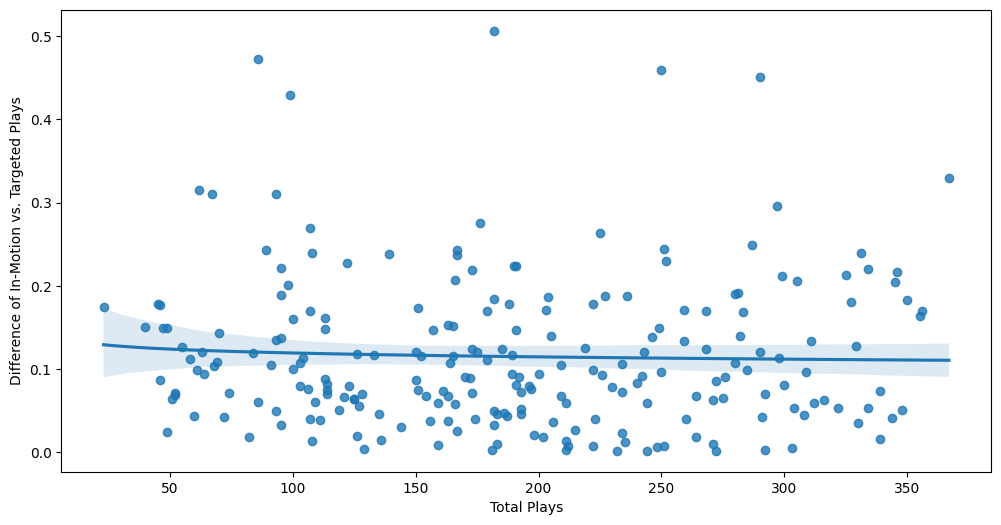

In [16]:
absolute_diff = df_minimum_motions["pctAbsoluteDiffMotions"].values
total_plays = df_minimum_motions["count"].values

plt.figure(figsize=(12,6))
sns.regplot(x=total_plays, y=absolute_diff, logx=True)

plt.xlabel('Total Plays')
plt.ylabel('Difference of In-Motion vs. Targeted Plays')

plt.show()

# Next Steps

1. What's the impact if we tune the thresholds in the section above?
2. What's the best way to set and test a decision bounday here?
3. How can we best implement a binary classifier, to train and test on the above data?
4. How does the data look different if we normalize the number of plays?
5. Can we test the binary classifiers on later weeks?
6. How does this data look if we group players by team, or by position?